## Directories etc

In [86]:
from __future__ import division

import codecs
import csv
import os
import time
from os import listdir
from os.path import isfile, join
import re
import io


# Directory and file names:

# ENGLISH
#dir_in = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "..", "hartlib","OneDrive", "lemmatization", "input_TM"))
#dir_out = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "..", "hartlib","OneDrive", "files_years", "en"))  # relative path to data directory
#dir_hartlib = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "..","hartlib", "OneDrive", "Hartlib Papers 2nd edition"))


# LATIN
dir_in = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "..", "hartlib","OneDrive", "lemmatization", "la","output"))
dir_out = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "..", "hartlib","OneDrive", "files_years", "la"))  # relative path to data directory
dir_hartlib = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "..","hartlib", "OneDrive", "Hartlib Papers 2nd edition"))



# create output directory if it doesn't exist:
if not os.path.exists(dir_out):
    os.makedirs(dir_out)

    
num_topics = 40

In [87]:
print(dir_in)
#/Users/hengchen/hartlib/OneDrive

/Users/hengchen/hartlib/OneDrive/lemmatization/la/output


## Get date from the files in Hartlib 2nd edition

In [88]:
file_year = {}
missing = list()
files_hartlib = [f for f in listdir(dir_hartlib) if isfile(join(dir_hartlib, f))]
for file in files_hartlib:   # for each file in the folder, we open hit and retrieve a date that is possible for us ([1][6][0-9]{2}).
    #print("file:" + file)
    text = open(os.path.join(dir_hartlib, file), 'r').readlines()
    i = 0
    for line in text:
        i += 1
        if i == 1:
            hit = re.search("[1][6][0-9]{2}",line) # We can't utilise the HTML because tags differ. Also, sometimes no true date but a guess (a full text)
        
            if hit:
                if hit.group(0) != "1000":
                    file_year[file[:-5]] = hit.group(0) # we remove ".html" and use that as dictionary key
            else :
                missing.append(file)

set_missing = set(missing)    

print("missing a date:")
print(len(set_missing))
#print(missing)        
print("letters with a date:")
print(len(file_year))
print("letters in the hartlib folder:")
print(len(files_hartlib))
#print(file_year)

missing a date:
1531
letters with a date:
3703
letters in the hartlib folder:
5234


## Getting the files in {language} to match them with the letters with a date
{language} being defined in the first cell

In [89]:
# We first recreate a list with the file ID, not the filename

files_in = [f for f in listdir(dir_in) if isfile(join(dir_in, f))]
print(len(files_in))
files_in_no = list()

for file in files_in:  # this creates a list with the file ID, not the filename
    #print(file[:-12])
    #files_in_no.append(file[:-12])      ### THIS IS FOR ENGLISH
    files_in_no.append(file[:-22])       ### THIS IS FOR LATIN 
    
    
    
#print(len(files_in_no))

# We then match

dico_en = dict()
liste_en_no_date = list()



#print(files_in_no)
#print("\n\n\n")
#print(missing)
z = 0
for chose in files_in_no:
    if chose in file_year:
        dico_en[chose] = file_year[chose]
        z = z+1


print(z)

for fichier in files_in_no:
    fichier = fichier+".html"
    if fichier in missing:
        liste_en_no_date.append(fichier)

print("{language} files with date:")
print(len(dico_en))
#print(dico_en)
print("{language} files with no date:")
print(len(liste_en_no_date))
#print(liste_en_no_date)

# here we check if the letters that don't have a date contain "reply", as sometimes the replies do contain a date

#print("dico EN: ",dico_en)

#x = 0

#for file in files_hartlib:
#    if file in liste_en_no_date:
#        fichier = open(dir_hartlib+"/"+file)
#        texte = fichier.readlines()
#        for line in texte:
#            if "reply to" in line:
#                print("oui "+file)
#                x = x+1
#print(x)



1536
946
{language} files with date:
946
{language} files with no date:
590


# Using the results of LDA
## We create dict_topic_year[filename] = [topic, year]  (might be useless as only one entry per file, recheck)

In [90]:
# this might be wrong as "several topics per file" !

#topics_csv = open(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "OneDrive", "TM_output", "40", "output_csv","DocsInTopics.csv")),"r")

### Below is for English
#topics_csv = open(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "..","hartlib", "OneDrive", "TM_output_2", "40", "output_csv","DocsInTopics.csv")),"r")

### Below is for Latin
topics_csv = open(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "..","hartlib", "OneDrive", "TM_output", "TM_output_LA3", "40", "output_csv","DocsInTopics.csv")),"r")

topics_csv = topics_csv.readlines()
print("Number of lines in the CSV: "+str(len(topics_csv)))

dict_topic_year = dict()

for line in topics_csv:
    line = line.rstrip()
    line = line.split(";")
    file_name = line[3]    # we retrieve the file name
    
    ###  This below is for English
    #file_name = file_name[64:-12]  # we keep the ID and remove the path
    
    ### This below is for Latin
    file_name = file_name[53:-22]
    
    if file_name in file_year:
        dict_topic_year[file_name] = [line[0],file_year[file_name]]  # we update the dictionary with filename as key, topic and year as data

print("Number of entries in the dictionary :"+str(len(dict_topic_year)))        
print(dict_topic_year)

Number of lines in the CSV: 20001
Number of entries in the dictionary :869
{'1B_33_039': ['39', '1648'], '1C_33_079': ['39', '1644'], '1B_33_022': ['39', '1648'], '1C_33_044': ['39', '1648'], '1C_33_094': ['39', '1648'], '1B_33_007': ['39', '1647'], '1C_33_099': ['39', '1648'], '7D_078': ['37', '1640'], '1C_33_067': ['39', '1648'], '1B_33_012': ['39', '1647'], '55A_01': ['39', '1634'], '26B_24': ['39', '1638'], '19A_01_20': ['39', '1622'], '1C_33_052': ['39', '1648'], '1B_33_033': ['37', '1648'], '1C_35_05': ['37', '1647'], '1C_36_07': ['36', '1648'], '19A_01_33': ['39', '1633'], '1C_33_102': ['39', '1649'], '12A_017': ['38', '1646'], '1C_34_11': ['39', '1647'], '56A_01_059': ['39', '1657'], '20A_01_28': ['39', '1635'], '7C_046': ['36', '1641'], '5C_29': ['38', '1639'], '18C_20': ['37', '1637'], '1B_33_026': ['39', '1648'], '20B_10_02': ['39', '1654'], '45B_03_23': ['39', '1642'], '26A_06': ['39', '1657'], '1B_33_003': ['34', '1646'], '18C_23': ['39', '1638'], '4A_01_01': ['37', '1647'

## Using topicsindoc.csv, take all top topics and the files that pertain to them
### Also, given the time slices, we create topic_slice_files which maps (topic, slice) to the corresponding files

In [91]:
#topicsindocs_csv = open(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "OneDrive", "TM_output", "40", "output_csv","TopicsInDocs.csv")),"r")
topicsindocs_csv = open(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "..","hartlib", "OneDrive", "TM_output", "TM_output_LA3", "40", "output_csv","TopicsInDocs.csv")),"r")
topicsindocs_csv = topicsindocs_csv.readlines()[1:] # skip the first line (headers)
dict_file_topic = dict()
list_topics = list()
topic_slice_files = dict() # maps a (topic, time slice) to the corresponding list of files

# slices = [1610,1635,1650,1675]
slices = [1610,1650,1665] # now trying with two slices

topic_year_number = dict()

## dico_en is file_year for ENGLISH

liste_annee = list(dico_en.values())

liste_annee_liste = liste_annee
liste_annee = list(set(liste_annee)) # all different years for which we have a file
#print(liste_annee)

print("\n\nTime Range: "+str(sorted(liste_annee)[0])+" --> "+str(sorted(liste_annee)[len(liste_annee)-1]))
total_of_years = int(sorted(liste_annee)[len(liste_annee)-1])-int(sorted(liste_annee)[0])
print("total of years",total_of_years,"\n")

yearz = list()
for i in range(int(sorted(liste_annee)[0]),int(sorted(liste_annee)[len(liste_annee)-1])):  # this is just to get all dates
    yearz.append(i)
print(yearz)

annee_count = dict()
for annee in liste_annee:
    annee_count[annee] = 0

for i in range(0,40):
    list_topics.append(i)
    dict_file_topic[i] = 0
#    topic_year_number[i] = dict(annee_count)  # for each of the topic number we have a dictionary with the year as key
#    for annee in liste_annee: 
        


for line in topicsindocs_csv:  # we discriminate on FILES
    line = line.rstrip()
    line = line.split(";")
   # print(line)
    
#    print(line) isinstance(1,int)
        
        #print(topic_number)
    #    x = 0
    
    #print(line)
    file_name_indocs = line[1]    # we retrieve the file name
    
    ### This is for English
    #file_name_indocs = file_name_indocs[64:-12]  # we keep the ID and remove the path
    
    ### This is for Latin
    file_name_indocs = file_name_indocs[53:-22]  # we keep the ID and remove the path
    
    
    j = 0
    topics_this_line = list()
    for col in line: 
        #print(col)
            
        if j % 2 == 0 and j > 0:  # we need j is at least 2, and even to capture the columns with topics
            topic = col

            if topic != "":
                topics_this_line.append(topic)
            
        j += 1
    
    for topic_number in topics_this_line:
        #print(topic_number)
        if file_name_indocs in file_year:
            year = file_year[file_name_indocs]
           
        
        
            if (topic_number, year) in topic_year_number:  # this is for the count
                topic_year_number[(topic_number, year)] += 1
            
            if (topic_number, year) not in topic_year_number:  # this is for the count
                topic_year_number[(topic_number, year)] = 1
                
            
            for s in range(0,len(slices)-1):
                if int(year) > slices[s] and int(year) <= slices[s+1]:
                    if (str(topic_number),s) in topic_slice_files.keys():
                        topic_slice_files[(str(topic_number),s)].append(file_name_indocs)
                    else:                        
                        topic_slice_files[(str(topic_number),s)] = [file_name_indocs]
                        print("topic number ",str(topic_number),"slice ",str(s),file_name_indocs)
                
                            
                    
    
#print(topic_year_number)
#for (topic, year) in topic_year_number: 
    
#    une_annee = topic_year_number[topic, year] 
#    if une_annee >= 50:
#        print("topic",topic,"year",year,"nombre une_annee",une_annee)
        # this above prints the topics for which, at a given year, there are at least 50 files
        
       
    # topic_year_number{} (topic,year): numberoffiles

    
#print("number of entries in topic_year_number:",len(topic_year_number.keys()))
# average of 28 years per topic


#for t in range(0,40):  # for each topic 
#    print("\n\ntopic",t)
#    comptage = 0
#
    
#    for key in topic_year_number.keys():  # for every key
#        if int(key[0]) == t:  # if int(first item in key) is the t we're currently dealing with
    
#            for y in range(0,total_of_years):  # for all values y between 0 and the total numbers of years we have
#                comptage = 0
                       
#                cette_annee = (key[0],key[1])[1]  # storing, in cette_annee, the year for topic t  (iteration)
                


                #if (key[0],cette_annee) in topic_year_number:  # if the key exists
                 #   print(key[0],cette_annee,topic_year_number[(key[0],cette_annee)])
            
                # if this date matches one of the dates we have AND the entry exists
#                if int(cette_annee) == yearz[y] and (key[0],cette_annee) in topic_year_number:  
                  
#                    comptage = comptage + topic_year_number[(key[0],cette_annee)] # we count
#                    print(cette_annee,comptage)
               
                




Time Range: 1610 --> 1669
total of years 59 

[1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668]
topic number  13 slice  0 10B_05_01
topic number  18 slice  0 10B_05_01
topic number  12 slice  0 10B_05_01
topic number  23 slice  0 10B_05_01
topic number  20 slice  0 11A_01_001
topic number  39 slice  0 11A_01_003
topic number  36 slice  0 11A_01_003
topic number  22 slice  0 11A_01_008
topic number  16 slice  0 11A_01_008
topic number  35 slice  0 11A_01_008
topic number  21 slice  0 11A_01_011
topic number  6 slice  0 11A_01_013
topic number  1 slice  0 11A_01_013
topic number  3 slice  0 11A_01_014
topic number  8 slice  0 11A_01_014
topic number  7 slice  0 11A_01_020
topic number  

In [92]:
print(len(topic_slice_files))
print(sorted(topic_slice_files[('0', 0)]))
#print(len(topic_slice_files[('0', 0)]))
#print(topic_slice_number['0', 0])

80
['11A_01_023', '11A_01_042', '11B_01_068', '11B_01_093', '11C_01_116', '11C_01_119', '12A_017', '12A_018', '12A_022', '12A_028', '18B_02_40', '18B_03_12D', '18C_20', '18C_23', '19A_01_33', '1A_02_05', '1A_22', '1B_33_003', '1B_33_006', '1B_33_007', '1B_33_012', '1B_33_018', '1B_33_020', '1B_33_022', '1B_33_026', '1B_33_033', '1B_33_039', '1C_33_043', '1C_33_044', '1C_33_052', '1C_33_056', '1C_33_060', '1C_33_062', '1C_33_067', '1C_33_068', '1C_33_074', '1C_33_094', '1C_33_099', '1C_33_102', '1C_34_11', '1C_34_13', '1C_35_05', '1C_36_07', '20A_01_28', '20A_04_15', '23A_05', '26B_24', '31B_12_01', '44A_01_08', '44A_01_11', '45B_03_19', '45B_03_20', '45B_03_23', '45B_03_25', '45C_04_01', '45C_04_03', '45C_04_04', '46A_06_03', '47A_09_34', '49A_02_01', '49A_03', '49A_08', '49A_10', '49B_24_02', '49B_30', '49B_32', '49B_33', '49B_45_01', '49B_45_03', '4A_01_01', '58_02', '59B_10_078', '5A_04_07', '5B_12_21', '5D_45_04', '5D_47', '5D_49', '5D_53_11', '5D_53_12', '6C_09', '7A_014', '7A_015

## Defining time slices
Getting for each topic the number of files per time slice

In [93]:
print(topic_year_number)

{('13', '1650'): 7, ('18', '1650'): 1, ('12', '1650'): 5, ('23', '1650'): 1, ('13', '1635'): 25, ('20', '1635'): 14, ('39', '1634'): 8, ('36', '1634'): 2, ('13', '1634'): 18, ('12', '1634'): 7, ('20', '1634'): 5, ('22', '1634'): 6, ('16', '1634'): 2, ('35', '1634'): 5, ('21', '1634'): 4, ('6', '1634'): 2, ('1', '1634'): 5, ('3', '1634'): 4, ('8', '1634'): 1, ('7', '1634'): 2, ('0', '1634'): 4, ('14', '1634'): 4, ('3', '1635'): 18, ('4', '1635'): 11, ('17', '1635'): 15, ('1', '1635'): 15, ('37', '1635'): 2, ('30', '1635'): 3, ('16', '1635'): 2, ('15', '1635'): 3, ('39', '1635'): 11, ('31', '1635'): 5, ('14', '1635'): 5, ('34', '1634'): 3, ('18', '1634'): 4, ('17', '1634'): 9, ('9', '1635'): 9, ('0', '1635'): 5, ('22', '1635'): 4, ('29', '1635'): 1, ('36', '1635'): 2, ('10', '1635'): 1, ('23', '1635'): 3, ('3', '1636'): 1, ('13', '1636'): 4, ('4', '1636'): 9, ('1', '1636'): 3, ('17', '1636'): 3, ('37', '1636'): 9, ('35', '1636'): 3, ('20', '1636'): 2, ('23', '1636'): 4, ('34', '1636'): 1

topic_slice_number = dict() #maps a (topic, time slice) to the corresponding number of files



for topic in range(40):  # for each topic
    topic = str(topic)
    print("\ntopic:",topic)
    for i in range(0,len(slices)-1): # for each of the slices
        print("slice number:", i)
    

        topic_slice_number[(topic, i)] = 0

        for x in range(slices[i],slices[i+1]):
            #print(x)
            x = str(x)
            if (topic,x) in topic_year_number:
                #print(topic_year_number[(topic,x)])
                topic_slice_number[(topic, i)] += topic_year_number[(topic,x)]
                                              
                # todo here append file names to topic_slice_files
                
        
        if topic_slice_number[(topic, i)] != 0:
            print(topic_slice_number[(topic, i)])
#topic_slice_number[('0',1)]            

In [94]:
topic_abc = dict()
for (t,s) in topic_slice_files:
    topic_abc[(t,s)] = len(topic_slice_files[(t,s)])

print(topic_abc[('0',0)])

100


## Copy the files to their corresponding folders slice/topic 


In [95]:
print(destination)
import shutil
from shutil import copyfile
topic_slice_files

/Users/hengchen/hartlib/OneDrive/files_years/la/Topics_by_slices_2/slice_0/0/4A_01_08_cleaned.txt


{('0', 0): ['11A_01_023',
  '11A_01_042',
  '11B_01_068',
  '11B_01_093',
  '11C_01_116',
  '11C_01_119',
  '12A_017',
  '12A_018',
  '12A_022',
  '12A_028',
  '18B_02_40',
  '18B_03_12D',
  '18C_20',
  '18C_23',
  '19A_01_33',
  '1A_02_05',
  '1A_22',
  '1B_33_003',
  '1B_33_006',
  '1B_33_007',
  '1B_33_012',
  '1B_33_018',
  '1B_33_020',
  '1B_33_022',
  '1B_33_026',
  '1B_33_033',
  '1B_33_039',
  '1C_33_043',
  '1C_33_044',
  '1C_33_052',
  '1C_33_056',
  '1C_33_060',
  '1C_33_062',
  '1C_33_067',
  '1C_33_068',
  '1C_33_074',
  '1C_33_094',
  '1C_33_099',
  '1C_33_102',
  '1C_34_11',
  '1C_34_13',
  '1C_35_05',
  '1C_36_07',
  '20A_01_28',
  '20A_04_15',
  '23A_05',
  '26B_24',
  '31B_12_01',
  '44A_01_08',
  '44A_01_11',
  '45B_03_19',
  '45B_03_20',
  '45B_03_23',
  '45B_03_25',
  '45C_04_01',
  '45C_04_03',
  '45C_04_04',
  '46A_06_03',
  '47A_09_34',
  '49A_02_01',
  '49A_03',
  '49A_08',
  '49A_10',
  '49B_24_02',
  '49B_30',
  '49B_32',
  '49B_33',
  '49B_45_01',
  '49B_45_

In [96]:
number_files_slices = list()
total_number_files = 0

for i in range(0,len(slices)-1):
    number_files_slices.append(0)

#)

for topic in range(0,num_topics):
    topic = str(topic)
    for i in range(0,len(slices)):
        if (topic,i) in topic_slice_files:
            for filename in topic_slice_files[(topic,i)]:
                #print(filename)
                
                ### THIS BELOW FOR ENGLISH
               # source = dir_in+"/"+filename+"_cleaned.txt"
                ### THIS BELOW FOR LATIN
                source = dir_in+"/"+filename+"_cleaned_la_lemmas.txt"
                #print(source)
                
                
                destination_folder = dir_out+"/Topics_by_slices_2/slice_"+str(i)+"/"+str(topic)+"/"
                destination_slice_folder = dir_out+"/Topics_by_slices_2/slice_"+str(i)+"/"+"_all_files/"
                destination = dir_out+"/Topics_by_slices_2/slice_"+str(i)+"/"+str(topic)+"/"+filename+"_cleaned.txt"
                destination_slice = dir_out+"/Topics_by_slices_2/slice_"+str(i)+"/"+"_all_files/"+filename+"_cleaned.txt"
                
                
                if not os.path.exists(destination_folder):
                    os.makedirs(destination_folder)


                if not os.path.exists(destination_slice_folder):
                    os.makedirs(destination_slice_folder)
                    
                if not os.path.exists(destination_slice_folder):
                    os.makedirs(destination_slice)

                copyfile(source, destination)  # file is in a slice/topic folder to which it pertains
                copyfile(source, destination_slice) # file is in a "all files in this slice" folder. Removes duplicates

                total_number_files += 1
                number_files_slices[i] += 1


print("number of files moved",str(total_number_files))
print(number_files_slices)
#print(len(topic_slice_files[('6', 2)]))

11A_01_023
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/11A_01_023_cleaned_la_lemmas.txt
11A_01_042
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/11A_01_042_cleaned_la_lemmas.txt
11B_01_068
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/11B_01_068_cleaned_la_lemmas.txt
11B_01_093
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/11B_01_093_cleaned_la_lemmas.txt
11C_01_116
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/11C_01_116_cleaned_la_lemmas.txt
11C_01_119
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/11C_01_119_cleaned_la_lemmas.txt
12A_017
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/12A_017_cleaned_la_lemmas.txt
12A_018
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/12A_018_cleaned_la_lemmas.txt
12A_022
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/12A_022_cleaned_la_lemmas.txt
12A_028
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/12A_028_cleaned_la_lemmas.txt
18B_02_40
/Use

56A_01_011
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/56A_01_011_cleaned_la_lemmas.txt
56A_01_016
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/56A_01_016_cleaned_la_lemmas.txt
56A_01_039
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/56A_01_039_cleaned_la_lemmas.txt
56A_01_043
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/56A_01_043_cleaned_la_lemmas.txt
56A_01_048
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/56A_01_048_cleaned_la_lemmas.txt
56A_01_051
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/56A_01_051_cleaned_la_lemmas.txt
56A_01_052
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/56A_01_052_cleaned_la_lemmas.txt
56A_01_055
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/56A_01_055_cleaned_la_lemmas.txt
56A_01_059
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/56A_01_059_cleaned_la_lemmas.txt
56A_01_063
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/56A_01_063_cleaned_la_l

7E_099
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7E_099_cleaned_la_lemmas.txt
7E_101
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7E_101_cleaned_la_lemmas.txt
7E_102
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7E_102_cleaned_la_lemmas.txt
7E_111_01
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7E_111_01_cleaned_la_lemmas.txt
7E_111_03
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7E_111_03_cleaned_la_lemmas.txt
7E_111_04
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7E_111_04_cleaned_la_lemmas.txt
7E_111_06
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7E_111_06_cleaned_la_lemmas.txt
7E_111_08
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7E_111_08_cleaned_la_lemmas.txt
7E_111_09
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7E_111_09_cleaned_la_lemmas.txt
7E_111_10
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7E_111_10_cleaned_la_lemmas.txt
7E_111_13
/Users/hengchen/ha

19A_03_11
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/19A_03_11_cleaned_la_lemmas.txt
19A_03_15
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/19A_03_15_cleaned_la_lemmas.txt
19A_04_01
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/19A_04_01_cleaned_la_lemmas.txt
19A_04_04
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/19A_04_04_cleaned_la_lemmas.txt
19A_05
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/19A_05_cleaned_la_lemmas.txt
19A_06
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/19A_06_cleaned_la_lemmas.txt
19A_07
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/19A_07_cleaned_la_lemmas.txt
19B_10_03
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/19B_10_03_cleaned_la_lemmas.txt
19B_10_07
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/19B_10_07_cleaned_la_lemmas.txt
19B_10_21
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/19B_10_21_cleaned_la_lemmas.txt
19B_10_30
/Users/hengchen/ha

40_06_07
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/40_06_07_cleaned_la_lemmas.txt
43B_60
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/43B_60_cleaned_la_lemmas.txt
43B_61
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/43B_61_cleaned_la_lemmas.txt
49A_22_04
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/49A_22_04_cleaned_la_lemmas.txt
49B_26
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/49B_26_cleaned_la_lemmas.txt
49B_34
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/49B_34_cleaned_la_lemmas.txt
49B_35_03
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/49B_35_03_cleaned_la_lemmas.txt
49B_41_03
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/49B_41_03_cleaned_la_lemmas.txt
4D_03_107
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/4D_03_107_cleaned_la_lemmas.txt
4D_03_133
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/4D_03_133_cleaned_la_lemmas.txt
4E_03_167
/Users/hengchen/hartlib/On

18C_18
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/18C_18_cleaned_la_lemmas.txt
18C_21
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/18C_21_cleaned_la_lemmas.txt
19A_04_01
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/19A_04_01_cleaned_la_lemmas.txt
19A_04_04
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/19A_04_04_cleaned_la_lemmas.txt
19B_11_022
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/19B_11_022_cleaned_la_lemmas.txt
19B_11_030
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/19B_11_030_cleaned_la_lemmas.txt
19B_11_038
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/19B_11_038_cleaned_la_lemmas.txt
1A_21_01
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/1A_21_01_cleaned_la_lemmas.txt
1B_28
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/1B_28_cleaned_la_lemmas.txt
22A_05_01
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/22A_05_01_cleaned_la_lemmas.txt
22A_05_03
/Users/hengchen/

43A_38
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/43A_38_cleaned_la_lemmas.txt
49B_39
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/49B_39_cleaned_la_lemmas.txt
4A_02_05
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/4A_02_05_cleaned_la_lemmas.txt
56A_01_002
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/56A_01_002_cleaned_la_lemmas.txt
56A_01_063
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/56A_01_063_cleaned_la_lemmas.txt
56B_01_107
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/56B_01_107_cleaned_la_lemmas.txt
8A_03
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/8A_03_cleaned_la_lemmas.txt
8A_09
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/8A_09_cleaned_la_lemmas.txt
14C_05_12
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/14C_05_12_cleaned_la_lemmas.txt
26D_84
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/26D_84_cleaned_la_lemmas.txt
30A_04_09
/Users/hengchen/hartlib/OneDri

5C_28_03
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/5C_28_03_cleaned_la_lemmas.txt
5C_29
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/5C_29_cleaned_la_lemmas.txt
5C_32_02
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/5C_32_02_cleaned_la_lemmas.txt
5C_39
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/5C_39_cleaned_la_lemmas.txt
5C_43
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/5C_43_cleaned_la_lemmas.txt
5D_45_01
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/5D_45_01_cleaned_la_lemmas.txt
5D_45_07
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/5D_45_07_cleaned_la_lemmas.txt
5D_48_01
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/5D_48_01_cleaned_la_lemmas.txt
5D_48_03
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/5D_48_03_cleaned_la_lemmas.txt
5D_54
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/5D_54_cleaned_la_lemmas.txt
60A_03_03
/Users/hengchen/hartlib/OneDrive/lemmatizati

1C_33_076
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/1C_33_076_cleaned_la_lemmas.txt
1C_33_094
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/1C_33_094_cleaned_la_lemmas.txt
1C_33_098
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/1C_33_098_cleaned_la_lemmas.txt
1C_33_102
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/1C_33_102_cleaned_la_lemmas.txt
1C_34_11
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/1C_34_11_cleaned_la_lemmas.txt
1C_34_13
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/1C_34_13_cleaned_la_lemmas.txt
1C_35_10
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/1C_35_10_cleaned_la_lemmas.txt
1C_35_11
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/1C_35_11_cleaned_la_lemmas.txt
20A_04_09
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/20A_04_09_cleaned_la_lemmas.txt
20A_06_01
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/20A_06_01_cleaned_la_lemmas.txt
21B_10
/Users/heng

16A_01_45
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/16A_01_45_cleaned_la_lemmas.txt
16A_01_47
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/16A_01_47_cleaned_la_lemmas.txt
16A_01_64
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/16A_01_64_cleaned_la_lemmas.txt
16A_02_02
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/16A_02_02_cleaned_la_lemmas.txt
16A_02_03
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/16A_02_03_cleaned_la_lemmas.txt
16A_02_04
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/16A_02_04_cleaned_la_lemmas.txt
16A_02_07
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/16A_02_07_cleaned_la_lemmas.txt
16A_02_09
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/16A_02_09_cleaned_la_lemmas.txt
16B_02_11
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/16B_02_11_cleaned_la_lemmas.txt
16B_02_13
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/16B_02_13_cleaned_la_lemmas.txt
16B_02_14


8A_09
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/8A_09_cleaned_la_lemmas.txt
8A_19
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/8A_19_cleaned_la_lemmas.txt
8C_54_03
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/8C_54_03_cleaned_la_lemmas.txt
9D_16_01
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/9D_16_01_cleaned_la_lemmas.txt
9D_16_05
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/9D_16_05_cleaned_la_lemmas.txt
9D_16_07
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/9D_16_07_cleaned_la_lemmas.txt
9D_16_08
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/9D_16_08_cleaned_la_lemmas.txt
9D_16_09
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/9D_16_09_cleaned_la_lemmas.txt
9D_16_11
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/9D_16_11_cleaned_la_lemmas.txt
9D_16_13
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/9D_16_13_cleaned_la_lemmas.txt
11A_01_025
/Users/hengchen/hartlib/OneDriv

14C_05_08
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/14C_05_08_cleaned_la_lemmas.txt
14C_05_30
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/14C_05_30_cleaned_la_lemmas.txt
15C_09_17
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/15C_09_17_cleaned_la_lemmas.txt
16A_01_13
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/16A_01_13_cleaned_la_lemmas.txt
16A_01_15
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/16A_01_15_cleaned_la_lemmas.txt
16A_01_17
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/16A_01_17_cleaned_la_lemmas.txt
16A_01_33
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/16A_01_33_cleaned_la_lemmas.txt
16A_01_41
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/16A_01_41_cleaned_la_lemmas.txt
16A_01_45
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/16A_01_45_cleaned_la_lemmas.txt
16A_01_64
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/16A_01_64_cleaned_la_lemmas.txt
16A_02_02


22B_23_01
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/22B_23_01_cleaned_la_lemmas.txt
26A_07
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/26A_07_cleaned_la_lemmas.txt
28_01_01
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/28_01_01_cleaned_la_lemmas.txt
28_01_14
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/28_01_14_cleaned_la_lemmas.txt
28_01_26
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/28_01_26_cleaned_la_lemmas.txt
28_01_49
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/28_01_49_cleaned_la_lemmas.txt
29_02_01
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/29_02_01_cleaned_la_lemmas.txt
29_02_12
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/29_02_12_cleaned_la_lemmas.txt
29_02_22
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/29_02_22_cleaned_la_lemmas.txt
29_02_33
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/29_02_33_cleaned_la_lemmas.txt
29_02_44
/Users/hengchen/hartlib

5C_29
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/5C_29_cleaned_la_lemmas.txt
5C_30
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/5C_30_cleaned_la_lemmas.txt
5D_47
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/5D_47_cleaned_la_lemmas.txt
5D_49
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/5D_49_cleaned_la_lemmas.txt
6C_06_19
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/6C_06_19_cleaned_la_lemmas.txt
7C_062
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7C_062_cleaned_la_lemmas.txt
7D_069
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7D_069_cleaned_la_lemmas.txt
7D_074
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7D_074_cleaned_la_lemmas.txt
7D_075
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7D_075_cleaned_la_lemmas.txt
7D_084_01
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7D_084_01_cleaned_la_lemmas.txt
7D_084_05
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7

62B_49_03
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/62B_49_03_cleaned_la_lemmas.txt
63B_14_13
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/63B_14_13_cleaned_la_lemmas.txt
64_06
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/64_06_cleaned_la_lemmas.txt
7C_061_04
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7C_061_04_cleaned_la_lemmas.txt
7C_061_06
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7C_061_06_cleaned_la_lemmas.txt
7C_061_11
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7C_061_11_cleaned_la_lemmas.txt
7C_061_14
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7C_061_14_cleaned_la_lemmas.txt
7C_061_16
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7C_061_16_cleaned_la_lemmas.txt
7D_072_01
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7D_072_01_cleaned_la_lemmas.txt
7D_080
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7D_080_cleaned_la_lemmas.txt
7E_099
/Users/hengchen/h

54_17
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/54_17_cleaned_la_lemmas.txt
56A_01_041
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/56A_01_041_cleaned_la_lemmas.txt
56A_01_048
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/56A_01_048_cleaned_la_lemmas.txt
56A_01_053
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/56A_01_053_cleaned_la_lemmas.txt
56A_01_069
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/56A_01_069_cleaned_la_lemmas.txt
56B_01_096
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/56B_01_096_cleaned_la_lemmas.txt
56B_01_160
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/56B_01_160_cleaned_la_lemmas.txt
60B_07_05
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/60B_07_05_cleaned_la_lemmas.txt
67_04
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/67_04_cleaned_la_lemmas.txt
7C_061_01
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7C_061_01_cleaned_la_lemmas.txt
7C_061_02
/Use

49B_43
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/49B_43_cleaned_la_lemmas.txt
4A_02_01
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/4A_02_01_cleaned_la_lemmas.txt
4B_03_010
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/4B_03_010_cleaned_la_lemmas.txt
4B_03_017
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/4B_03_017_cleaned_la_lemmas.txt
4D_03_100
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/4D_03_100_cleaned_la_lemmas.txt
4D_03_133
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/4D_03_133_cleaned_la_lemmas.txt
4E_03_162
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/4E_03_162_cleaned_la_lemmas.txt
4F_04_14
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/4F_04_14_cleaned_la_lemmas.txt
54_18
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/54_18_cleaned_la_lemmas.txt
54_20
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/54_20_cleaned_la_lemmas.txt
56A_01_021
/Users/hengchen/hartlib/O

60B_07_06
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/60B_07_06_cleaned_la_lemmas.txt
64_04
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/64_04_cleaned_la_lemmas.txt
64_06
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/64_06_cleaned_la_lemmas.txt
64_22
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/64_22_cleaned_la_lemmas.txt
65_18_03
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/65_18_03_cleaned_la_lemmas.txt
65_18_05
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/65_18_05_cleaned_la_lemmas.txt
67_04
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/67_04_cleaned_la_lemmas.txt
68_03_21
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/68_03_21_cleaned_la_lemmas.txt
7F_126
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7F_126_cleaned_la_lemmas.txt
8A_03
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/8A_03_cleaned_la_lemmas.txt
8A_18
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output

19B_11_094
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/19B_11_094_cleaned_la_lemmas.txt
19B_11_102
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/19B_11_102_cleaned_la_lemmas.txt
19B_11_106A
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/19B_11_106A_cleaned_la_lemmas.txt
19B_11_106B
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/19B_11_106B_cleaned_la_lemmas.txt
19B_11_107
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/19B_11_107_cleaned_la_lemmas.txt
19B_11_108
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/19B_11_108_cleaned_la_lemmas.txt
19B_11_113
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/19B_11_113_cleaned_la_lemmas.txt
1B_25_01
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/1B_25_01_cleaned_la_lemmas.txt
20A_01_24
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/20A_01_24_cleaned_la_lemmas.txt
20A_01_28
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/20A_01_28_cleaned_la_lemma

31D_22_01
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/31D_22_01_cleaned_la_lemmas.txt
40_01
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/40_01_cleaned_la_lemmas.txt
45C_06_16
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/45C_06_16_cleaned_la_lemmas.txt
5C_42_01
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/5C_42_01_cleaned_la_lemmas.txt
67_01_01
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/67_01_01_cleaned_la_lemmas.txt
67_01_07
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/67_01_07_cleaned_la_lemmas.txt
67_01_11
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/67_01_11_cleaned_la_lemmas.txt
6C_06_15
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/6C_06_15_cleaned_la_lemmas.txt
14C_05_16
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/14C_05_16_cleaned_la_lemmas.txt
27B_24
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/27B_24_cleaned_la_lemmas.txt
54_14
/Users/hengchen/hartlib/OneD

38_10
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/38_10_cleaned_la_lemmas.txt
44A_01_11
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/44A_01_11_cleaned_la_lemmas.txt
45B_03_25
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/45B_03_25_cleaned_la_lemmas.txt
49B_23
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/49B_23_cleaned_la_lemmas.txt
50_05
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/50_05_cleaned_la_lemmas.txt
54_01_07
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/54_01_07_cleaned_la_lemmas.txt
59B_10_039
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/59B_10_039_cleaned_la_lemmas.txt
59B_10_068
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/59B_10_068_cleaned_la_lemmas.txt
59B_10_158
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/59B_10_158_cleaned_la_lemmas.txt
5A_04_07
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/5A_04_07_cleaned_la_lemmas.txt
5D_45_01
/Users/hengchen/hartl

5C_29
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/5C_29_cleaned_la_lemmas.txt
5C_35
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/5C_35_cleaned_la_lemmas.txt
6C_06_19
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/6C_06_19_cleaned_la_lemmas.txt
6C_09
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/6C_09_cleaned_la_lemmas.txt
7D_069
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7D_069_cleaned_la_lemmas.txt
7E_109
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/7E_109_cleaned_la_lemmas.txt
9A_01_103
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/9A_01_103_cleaned_la_lemmas.txt
9A_01_151
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/9A_01_151_cleaned_la_lemmas.txt
11C_01_120
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/11C_01_120_cleaned_la_lemmas.txt
17_05
/Users/hengchen/hartlib/OneDrive/lemmatization/la/output/17_05_cleaned_la_lemmas.txt
17_07_05
/Users/hengchen/hartlib/OneDrive/lemmatizatio

In [297]:
#print(len(topic_slice_files['0',1]))
#print(sorted(topic_slice_files['0',1]))

#print(topic_abc[('0',1)])

In [104]:
# List of labels for the topics. Manually created by Robin
# this is hardcoded for now, next step is reading a file

topic_labels = ["newsletters about politics", 
               "friendship", 
               "religion: spirituality/faith", 
               "religion: church life", 
               "religious war/peace", 
               "Underspecified_actions",
               "letter writing/copying", 
               "trade of agricultural produce/plantations",
               "advancement of learning for the public good",
               "spirituality/dreams",
               "making cider/horticulture",
               "alchemy",
               "visiting/travelling",
               "poverty/charity(?)",
               "(writing) books/manuscripts",
               "personal relationships",
               "medicine: medicinal herbs",
               "education, learning languages",
               "medicine: (iatro) chemical experiments",
               "Office of Address (public office for jobs/knowledge)",
               "army/military/troop movement",
               "making an engine (water/manure)/technology/inventions",
               "Underspecified_colonies/settlers",
               "fear and hope",
               "plans for innovations in fishing presented to Parliament",
               "garbage topic",
               "war/peace between nations",
               "agriculture",
               "religion: morality/sin",
               "knowledge",
               "letter writing/sending",
               "law",
               "religion: fear and hope",
               "horticulture/husbandry",
               "academic life/publishing of academic books",
               "natural philosophy (physics)",
               "money/selling and buying",
               "religion: church/charity",
               "religion: theology/doctrine",
               "writing/editing (more about books than letters)"]
print(topic_labels)

topic_labels_la = list()

### This below is for Latin
for i in topic_labels:
    la = "INCORRECT LABEL"+i
    topic_labels_la.append(la)
    
#print(topic_abc)

['newsletters about politics', 'friendship', 'religion: spirituality/faith', 'religion: church life', 'religious war/peace', 'Underspecified_actions', 'letter writing/copying', 'trade of agricultural produce/plantations', 'advancement of learning for the public good', 'spirituality/dreams', 'making cider/horticulture', 'alchemy', 'visiting/travelling', 'poverty/charity(?)', '(writing) books/manuscripts', 'personal relationships', 'medicine: medicinal herbs', 'education, learning languages', 'medicine: (iatro) chemical experiments', 'Office of Address (public office for jobs/knowledge)', 'army/military/troop movement', 'making an engine (water/manure)/technology/inventions', 'Underspecified_colonies/settlers', 'fear and hope', 'plans for innovations in fishing presented to Parliament', 'garbage topic', 'war/peace between nations', 'agriculture', 'religion: morality/sin', 'knowledge', 'letter writing/sending', 'law', 'religion: fear and hope', 'horticulture/husbandry', 'academic life/pub

## Visualising the number of files per topic per slice

0 [7.524454477050414, 6.217070600632244]
1 [8.878856282919488, 6.954689146469969]
2 [3.762227238525207, 1.1591148577449948]
3 [3.310759969902182, 1.6859852476290833]
4 [12.415349887133182, 9.799789251844047]
5 [1.2039127163280663, 0.5268703898840885]
6 [2.18209179834462, 6.533192834562698]
7 [2.2573363431151243, 1.36986301369863]
8 [0.526711813393529, 2.6343519494204424]
9 [4.213694507148232, 2.845100105374078]
10 [0.9781790820165538, 2.107481559536354]
11 [0.8276899924755455, 4.004214963119073]
12 [6.922498118886381, 8.851422550052687]
13 [17.45673438675696, 20.969441517386723]
14 [3.8374717832957113, 5.268703898840885]
15 [5.568096313017306, 6.4278187565858795]
16 [5.568096313017306, 4.531085353003161]
17 [4.439428141459744, 3.6880927291886194]
18 [5.342362678705793, 4.7418335089567965]
19 [1.9563581640331076, 1.791359325605901]
20 [5.718585402558315, 6.8493150684931505]
21 [2.708803611738149, 0.5268703898840885]


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


22 [6.997742663656885, 9.483667017913593]
23 [8.051166290443943, 5.900948366701791]
24 [5.191873589164786, 3.161222339304531]
25 [0.526711813393529, 0.5268703898840885]
26 [0.8276899924755455, 9.062170706006322]
27 [0.8276899924755455, 2.4236037934668073]
28 [1.3544018058690745, 2.107481559536354]
29 [0.8276899924755455, 0.2107481559536354]
30 [2.3325808878856282, 1.6859852476290833]
31 [7.975921745673439, 2.3182297154899896]
32 [1.7306245297215952, 2.212855637513172]
33 [1.2039127163280663, 0.31612223393045313]
34 [9.255079006772009, 5.795574288724974]
35 [2.106847253574116, 6.006322444678609]
36 [1.2791572610985704, 1.36986301369863]
37 [6.696764484574868, 2.73972602739726]
38 [0.8276899924755455, 0.8429926238145417]
39 [6.094808126410835, 5.795574288724974]


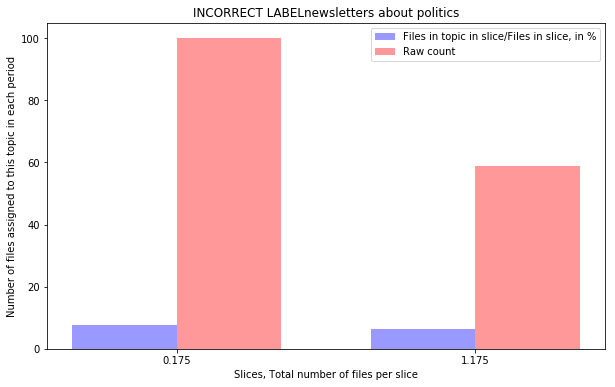

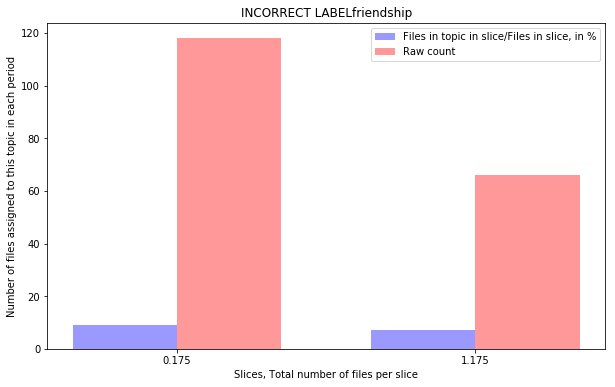

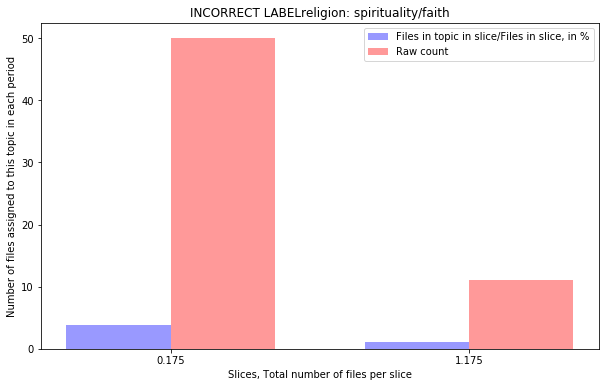

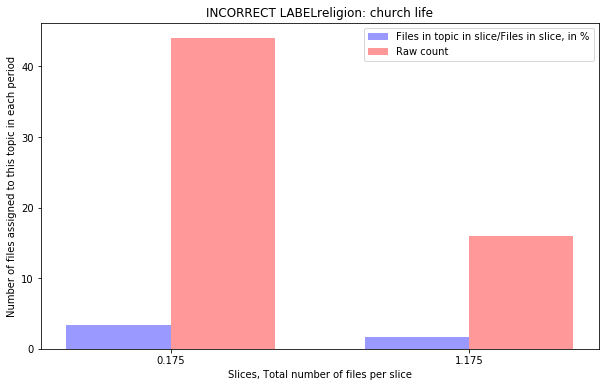

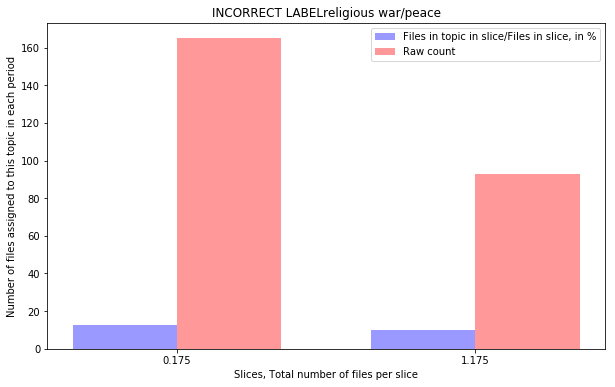

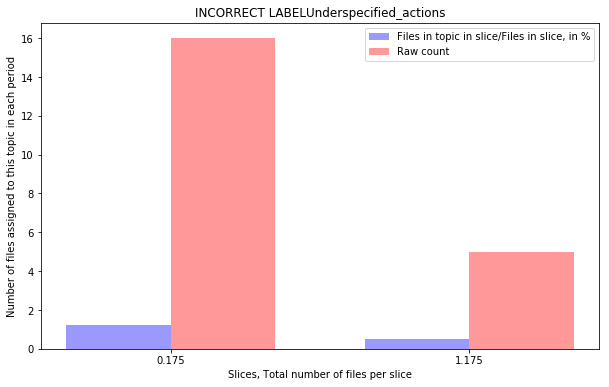

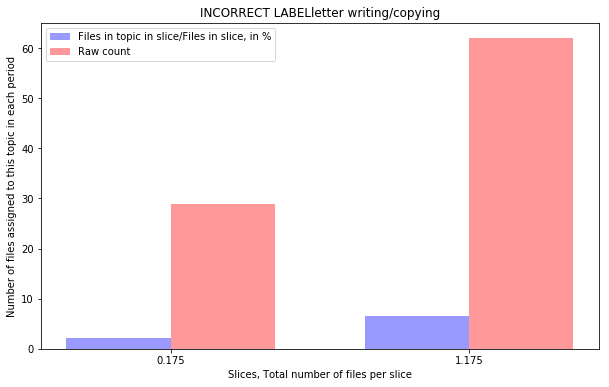

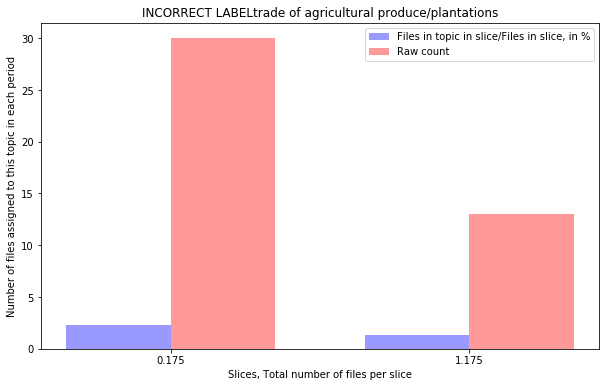

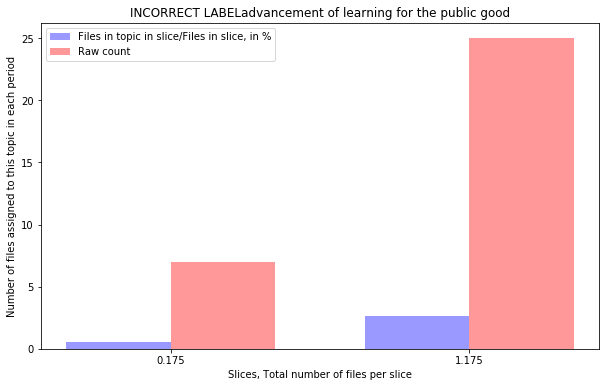

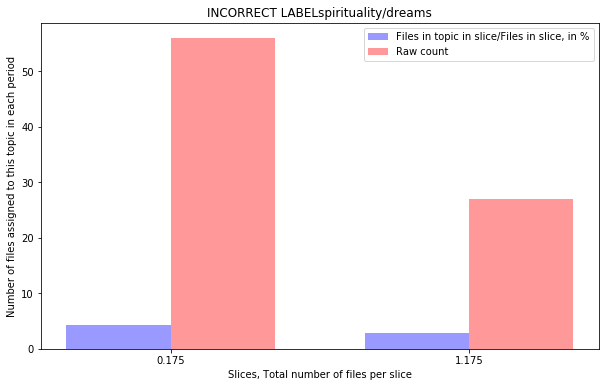

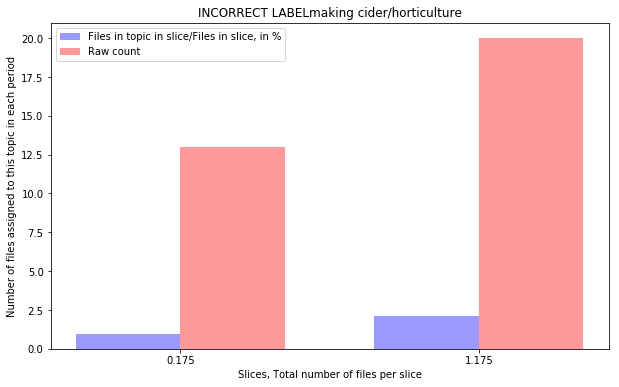

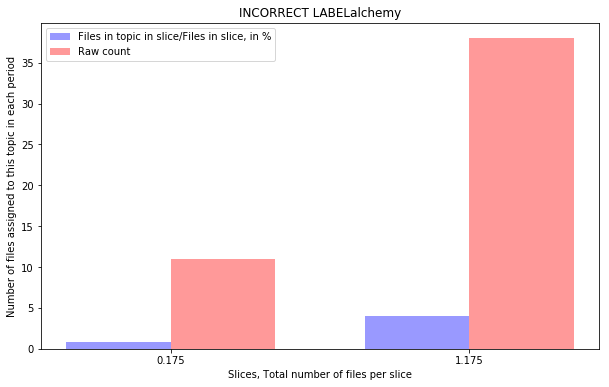

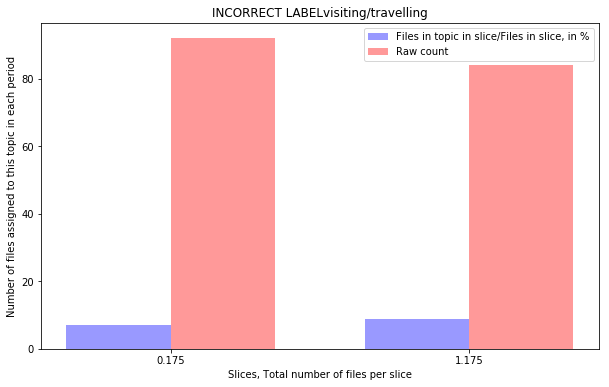

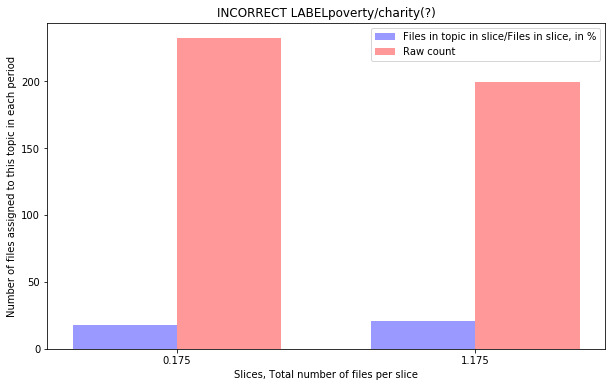

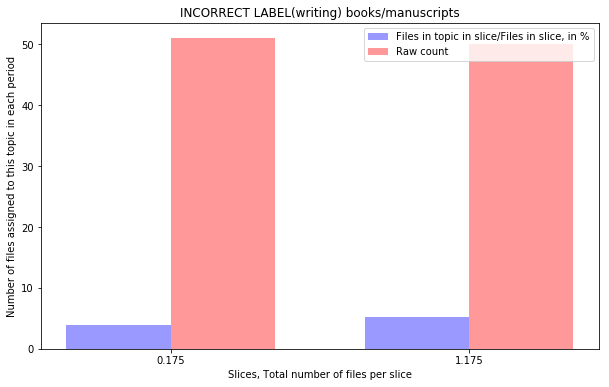

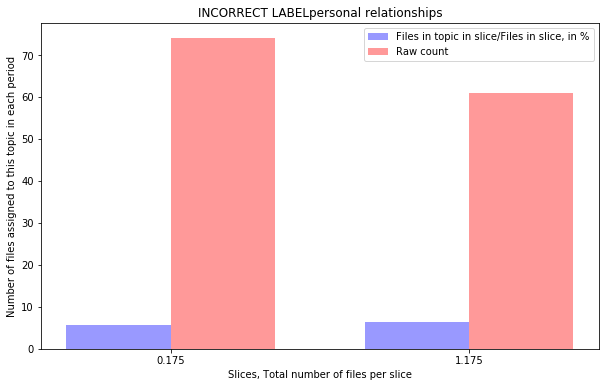

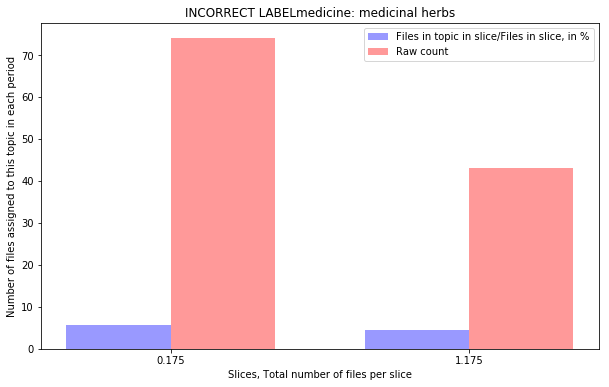

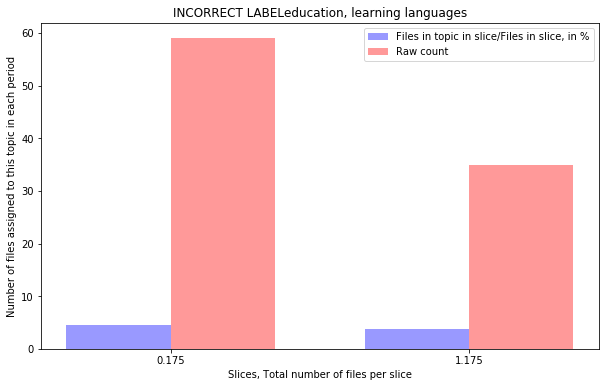

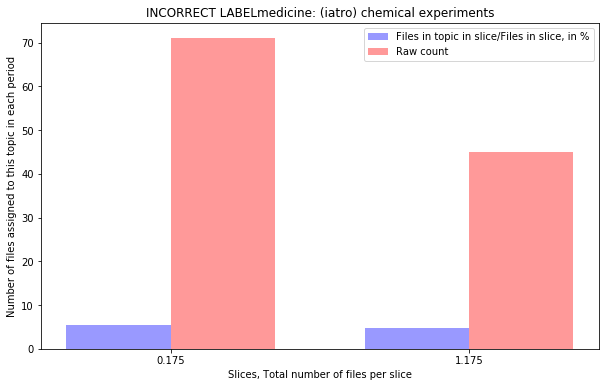

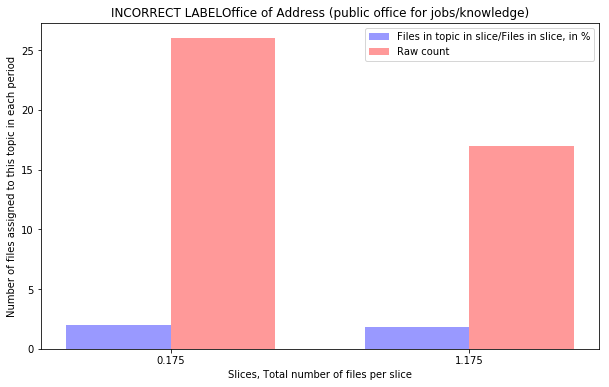

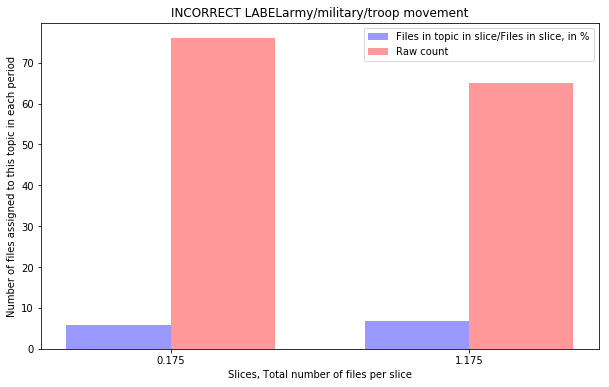

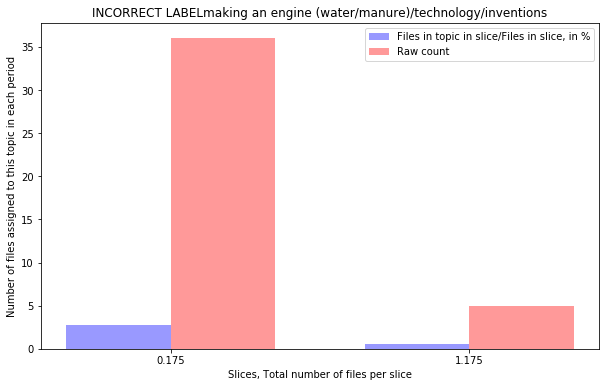

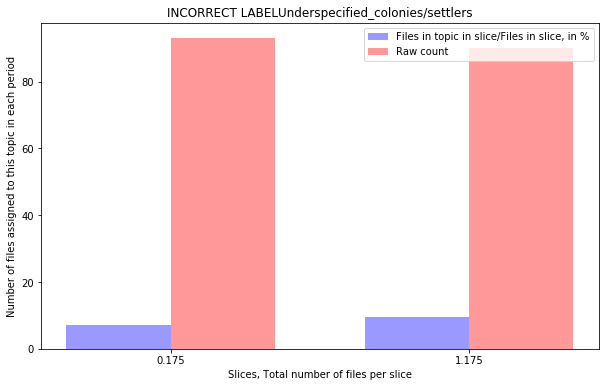

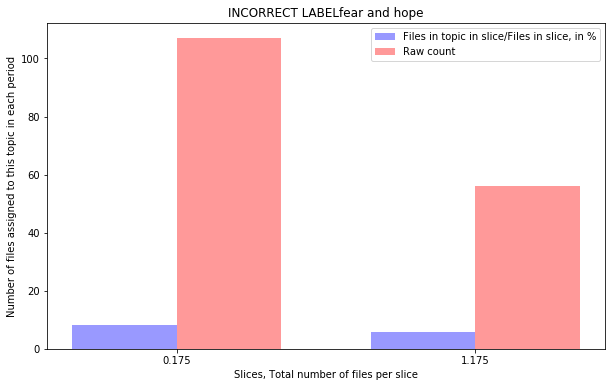

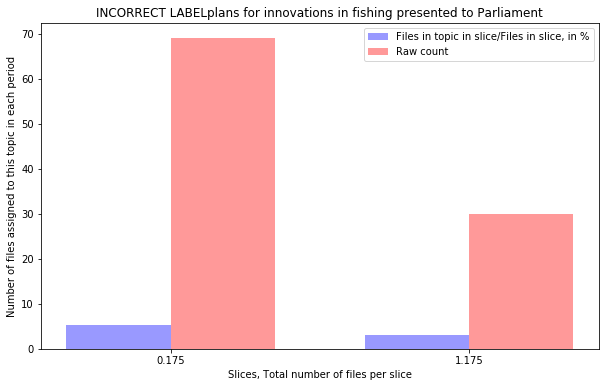

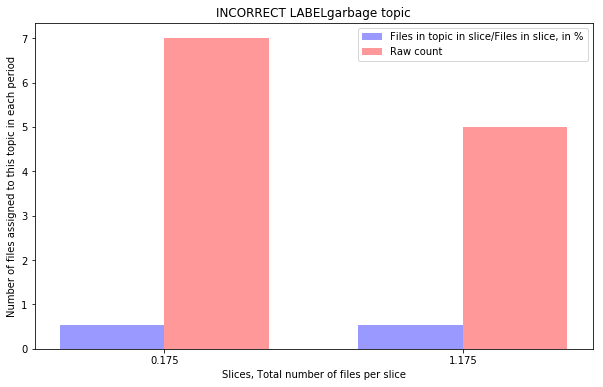

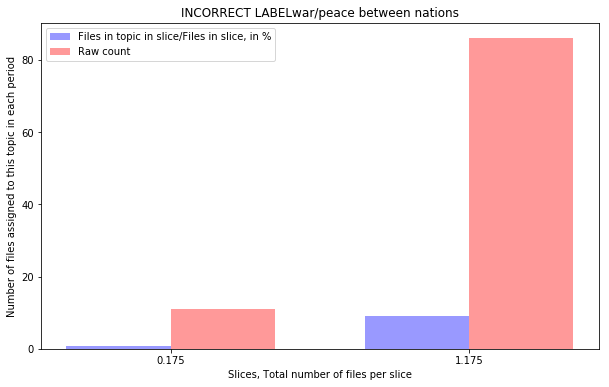

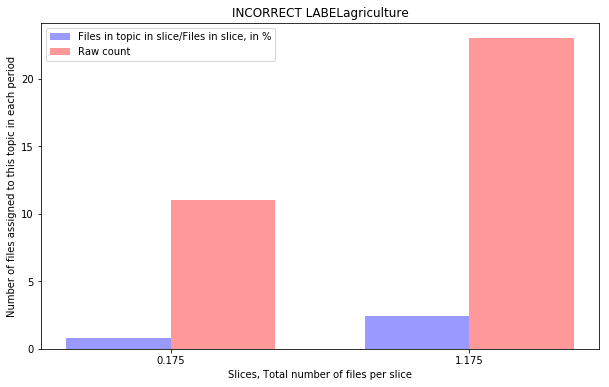

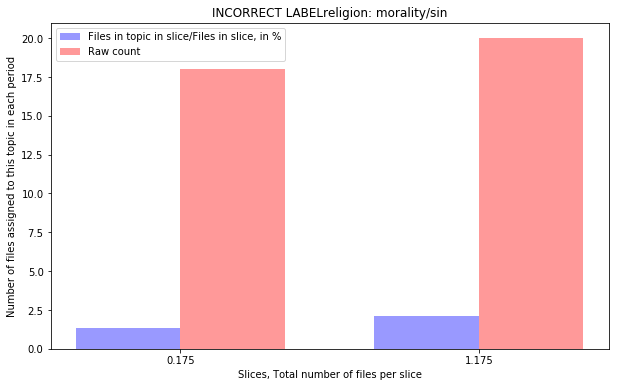

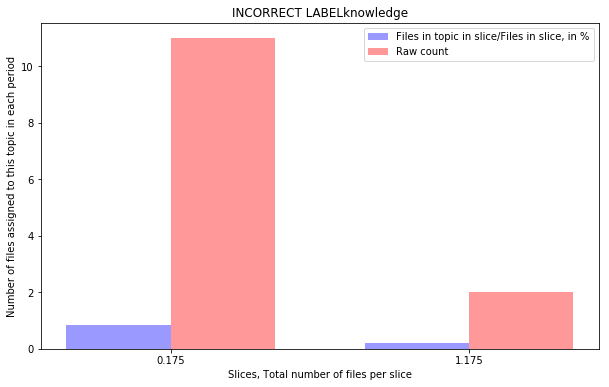

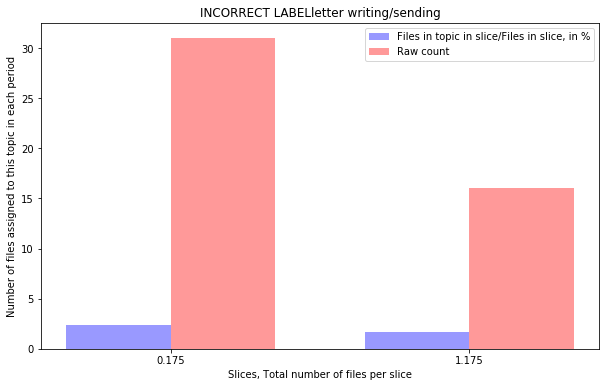

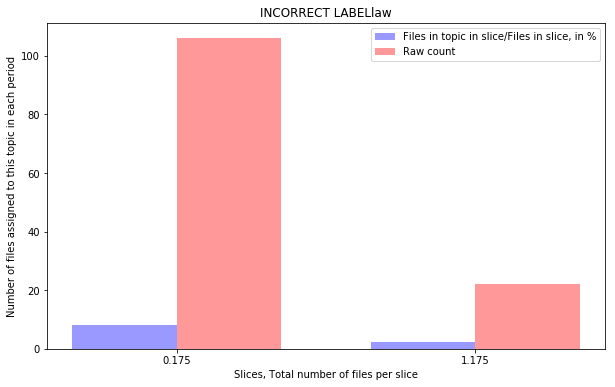

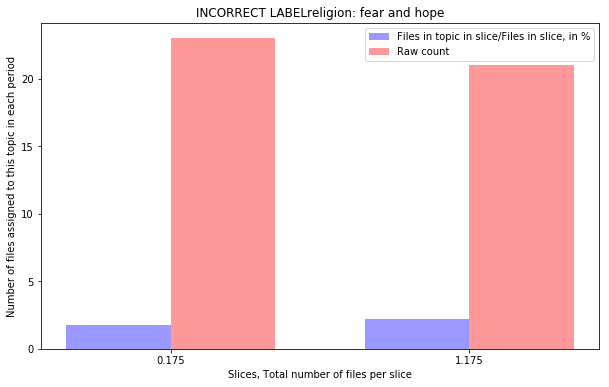

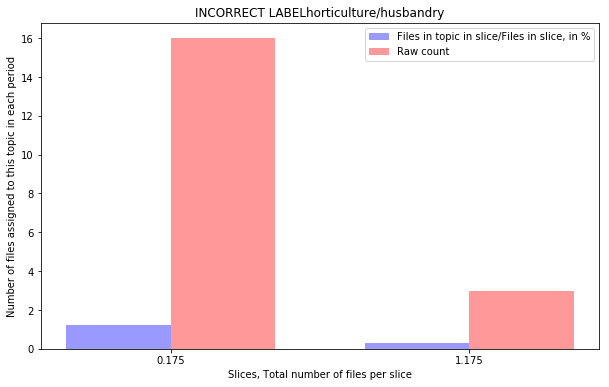

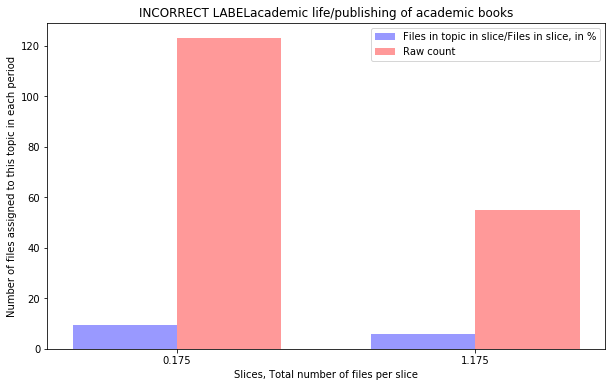

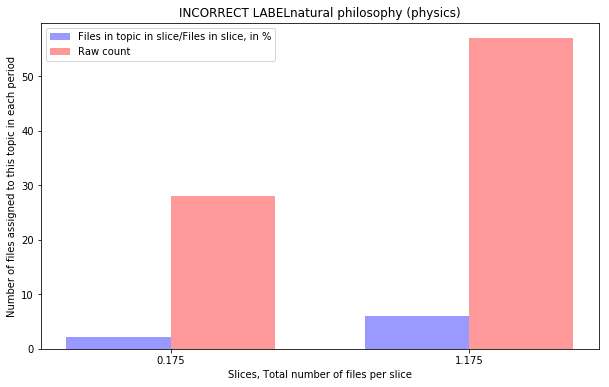

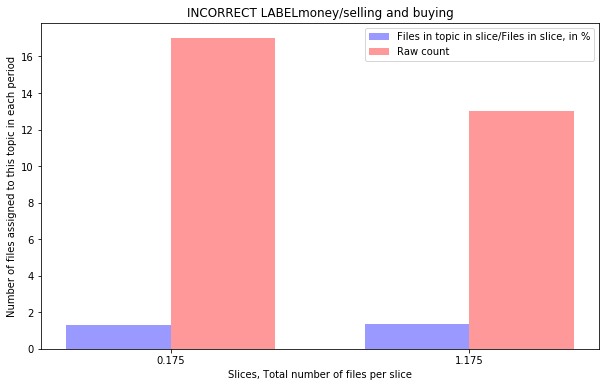

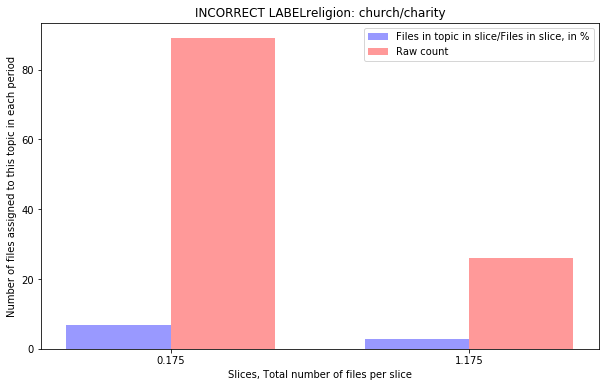

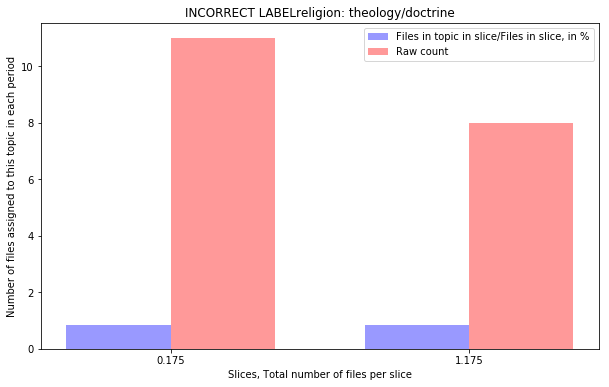

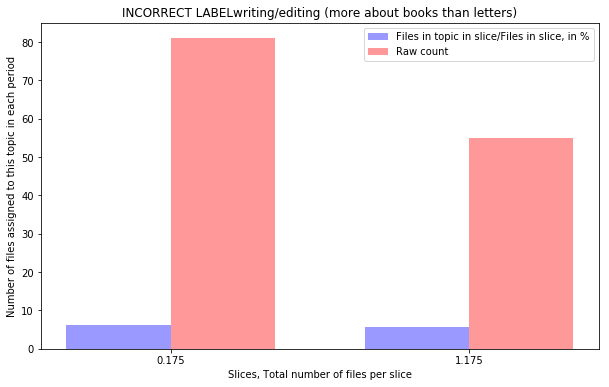

{('13', 0): 232, ('18', 0): 71, ('12', 0): 92, ('23', 0): 107, ('20', 0): 76, ('39', 0): 81, ('36', 0): 17, ('22', 0): 93, ('16', 0): 74, ('35', 0): 28, ('21', 0): 36, ('6', 0): 29, ('1', 0): 118, ('3', 0): 44, ('8', 0): 7, ('7', 0): 30, ('0', 0): 100, ('14', 0): 51, ('4', 0): 165, ('17', 0): 59, ('37', 0): 89, ('30', 0): 31, ('15', 0): 74, ('31', 0): 106, ('34', 0): 123, ('9', 0): 56, ('29', 0): 11, ('10', 0): 13, ('23', 1): 56, ('37', 1): 26, ('14', 1): 50, ('34', 1): 55, ('19', 1): 17, ('31', 1): 22, ('13', 1): 199, ('12', 1): 84, ('22', 1): 90, ('4', 1): 93, ('15', 1): 61, ('17', 1): 35, ('26', 0): 11, ('32', 0): 23, ('27', 0): 11, ('30', 1): 16, ('25', 0): 7, ('26', 1): 86, ('11', 1): 38, ('6', 1): 62, ('11', 0): 11, ('8', 1): 25, ('33', 1): 3, ('25', 1): 5, ('7', 1): 13, ('20', 1): 65, ('35', 1): 57, ('39', 1): 55, ('0', 1): 59, ('24', 0): 69, ('38', 1): 8, ('9', 1): 27, ('10', 1): 20, ('16', 1): 43, ('1', 1): 66, ('24', 1): 30, ('3', 1): 16, ('28', 1): 20, ('27', 1): 23, ('2', 1

<Figure size 720x432 with 0 Axes>

In [105]:
##### CHANGE NUMBERS LINES 38 & 41


import pylab
import numpy as np
from array import array
import matplotlib.pyplot as plt


pylab.rcParams['figure.figsize'] = (10, 6) # this is for bigger figures

n_groups = len(slices)-1  # the number of bars we'll have, i.e the number of slices


for t in range(0,num_topics):
    
    bars = list()
    bar_width = 0.35
    bars_raw = list()

    
    
    
    for i in range(0,n_groups):

#        if (str(t),i) in topic_abc:
    
#            bars.append(1000*topic_abc[(str(t),i)]/number_files_slices[i])
            
            #number_files_slices[i] is the total number of files for slice i, with duplicates (one file in several topics)
#            bars_raw.append(topic_abc[(str(t),i)])


# above is the correct way with duplicates, here I am using unique numbers

        if (str(t),i) in topic_abc:
            if i == 0:
                bars.append(100*topic_abc[(str(t),i)]/1329) # 1329 = number of unique files in slice 0
            
            if i == 1:
                bars.append(100*topic_abc[(str(t),i)]/949) # 949 = number of unique files in slice 1

        else:
            bars.append(0) # In case we don't have anything, we store a zero
        bars_raw.append(topic_abc[(str(t),i)])

        
        
    print(t,bars)
    fig, ax = plt.subplots()

    index = np.arange(n_groups)

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    rects1 = plt.bar(index, bars, bar_width,
                     alpha=opacity,
                     color='b',
                      #  yerr=std_men,
                     error_kw=error_config,
                     label='Files in topic in slice/Files in slice, in %')
    
    rects2 = plt.bar(index + bar_width, bars_raw, bar_width,
                 alpha=opacity,
                 color='r',
                 #yerr=std_women,
                 error_kw=error_config,
                 label='Raw count')
                     
    plt.xlabel('Slices, Total number of files per slice')
    plt.ylabel('Number of files assigned to this topic in each period')
    
    plt.title(topic_labels_la[t])
    #plt.xticks(index + bar_width / 2, (str(slices[i])+' to '+str(slices[i+1]), str(slices[1])+' to '+str(slices[2]), str(slices[2]) +' to' +str(slices[3])))
    plt.xticks(index + bar_width / 2)

    plt.legend()


    plt.savefig(dir_out+"/Topic "+str(t)+".png")
    #plt.savefig("ELEPHANT.PNG")

plt.show()
plt.gcf().clear()
print(topic_abc)
#plt.bar(list(topic_slice_number.keys()), dict_file_topic.values(), color='g')
#plt.title("Number of files per topic")
#plt.show()

#ax_f.set_ylabel('Fahrenheit')
#ax_c.set_ylabel('Celsius')

## comment on "files in topic in slice / files in slice" :
### we do the division on the duplicates and not on the exact number of files (as one file is in several topics)

In [81]:
print(topic_abc[('0', 0)])

print(topic_year_number)

3
{('27', '1647'): 1, ('39', '1647'): 3, ('12', '1647'): 2, ('36', '1647'): 1, ('18', '1647'): 1, ('35', '1647'): 2, ('30', '1649'): 1, ('17', '1649'): 1, ('30', '1640'): 1, ('24', '1640'): 1, ('21', '1640'): 1, ('17', '1640'): 1, ('21', '1641'): 1, ('30', '1641'): 1, ('12', '1641'): 1, ('29', '1641'): 1, ('24', '1641'): 1, ('15', '1641'): 1, ('9', '1641'): 1, ('7', '1641'): 2, ('2', '1650'): 1, ('30', '1650'): 2, ('18', '1650'): 1, ('7', '1650'): 1, ('32', '1650'): 1, ('2', '1642'): 4, ('21', '1642'): 6, ('7', '1642'): 1, ('30', '1642'): 5, ('10', '1642'): 1, ('22', '1642'): 2, ('20', '1642'): 1, ('24', '1642'): 3, ('9', '1642'): 2, ('4', '1642'): 1, ('16', '1642'): 1, ('2', '1657'): 1, ('32', '1657'): 1, ('7', '1657'): 1, ('16', '1657'): 1, ('6', '1640'): 2, ('13', '1640'): 1, ('26', '1640'): 1, ('15', '1640'): 1, ('13', '1647'): 9, ('30', '1647'): 2, ('11', '1647'): 1, ('6', '1647'): 1, ('17', '1647'): 4, ('0', '1647'): 2, ('31', '1647'): 1, ('21', '1647'): 1, ('20', '1647'): 2, ('1

In [101]:
threshold_of_files = 50 # this number is decided by us. Min number of files per topic in both slices

topic_threshold = list()

for t in range(0,num_topics):
   
    
    for i in range(0,n_groups):

        if (str(t),i) in topic_abc and (str(t),i+1) in topic_abc :
            if topic_abc[(str(t),i)] >= threshold_of_files and topic_abc[(str(t),i+1)] >= threshold_of_files:
                #print("topic, number of files for which both slices have more than threshold_of_files files:\n"+str(t),topic_abc[(str(t),i)],topic_abc[(str(t),i+1)])
                topic_threshold.append(t) 

print(topic_threshold)   
print(len(topic_threshold))

                
for topic in topic_threshold:
    print(topic,topic_labels[topic])


[0, 1, 4, 12, 13, 14, 15, 20, 22, 23, 34, 39]
12
0 newsletters about politics
1 friendship
4 religious war/peace
12 visiting/travelling
13 poverty/charity(?)
14 (writing) books/manuscripts
15 personal relationships
20 army/military/troop movement
22 Underspecified_colonies/settlers
23 fear and hope
34 academic life/publishing of academic books
39 writing/editing (more about books than letters)


## todo

- [x] two slices

- [x] filter correct years 
- [x] testing topic slice number
- [x] retrieve files pertaining to topics in different time slices 
- [x] visualisation -> will show what topics appeared and disappeared (account for number of files)

- [ ] run LDA with k = 1 on the slices for each of the 20 topics -- top words = 100, and we check the top 10 for changes

- [ ] for every topic find the difference between the words in slice 1 and the words in slice 2 for that topic
- [ ] consider trends in topic when interpreting results


- [x] normalise the number of letters per time slice (--> normalise number of files by all the files in that time slice) /_\ WE NEED CONFIDENCE INTERVAL
- [ ] optional: visualise the topic freq by time slice (+ find heuristic for "interesting trend", eg one slice is greater or equal than the sum of the two others)